## Setup

In [2]:
from pathlib import Path
import os

# Define paths based on environment
if Path("/kaggle").exists():
    os.environ["AMBIENTE"] = "KAGGLE"
    os.environ["TENSORBOARD_NO_TF"] = "1"

    PATH_DATASET = Path("/kaggle/working/STROKE_PREDICTION")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET
elif Path("/content").exists():
    os.environ["AMBIENTE"] = "COLAB"
    PATH_DATASET = Path("/content/DELETAR")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"
else:
    os.environ["AMBIENTE"] = "LOCAL"
    PATH_CODE = Path.cwd()
    PATH_DATASET = PATH_CODE.parent
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"


# Check if installation has been done
INSTALL_MARKER = PATH_DATASET / ".install_complete"
try:
    if not INSTALL_MARKER.exists():
        # Install uv
        pass
        !pip install uv

        # Environment-specific setup
        if os.environ["AMBIENTE"] == "KAGGLE":
            import kaggle_secrets

            user_secrets = kaggle_secrets.UserSecretsClient()
            github_pat = user_secrets.get_secret("GITHUB_PAT")

            os.chdir("/kaggle/working")
            os.system(
                f"git clone https://{github_pat}@github.com/lfaoliveira/STROKE_PREDICTION.git"
            )
            os.chdir(PATH_DATASET)

        elif os.environ["AMBIENTE"] == "LOCAL":
            os.system("git pull origin main")

        # Install dependencies
        os.chdir(PATH_DATASET)
        os.system("uv pip install --requirements pyproject.toml --system")

        if os.environ["AMBIENTE"] == "KAGGLE":
            os.system(
                "uv pip install --upgrade --force-reinstall --no-cache-dir scipy numpy matplotlib"
            )

        # Mark installation as complete
        INSTALL_MARKER.touch()
        print("Installation completed")
    else:
        print("Installation already completed, skipping...")

    os.chdir(PATH_CODE)
    print(f"Current working directory: {os.getcwd()}")
except Exception:
    print("FALHA AO INICIAR NOTEBOOK")

Installation already completed, skipping...
Current working directory: c:\Users\LUIS_FELIPE\Desktop\PROJETO_PESS_DADOS\src


## Exploratory Data Analysis

In [ ]:
from DataProcesser.dataset import StrokeDataset
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Load data
# =========================
df = StrokeDataset().original_df.copy()

# =========================
# 1. Dataset overview
# =========================
print("Shape:", df.shape)
print(df.info())
print("\nMissing values:\n", df.isna().sum())

# =========================
# 2. Target distribution
# =========================
stroke_dist = df["stroke"].value_counts(normalize=True) * 100
print("\nStroke distribution (%):\n", stroke_dist)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# =========================
# 1. Stroke distribution
# =========================
df["stroke"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Stroke Distribution (Imbalanced)")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["No Stroke", "Stroke"], rotation=0)
axes[0].set_ylabel("Count")
axes[0].set_yticks([i for i in range(0, 4501, 500)])
# =========================
# 2. Age vs Stroke
# =========================
df.boxplot(column="age", by="stroke", ax=axes[1])
axes[1].set_title("Age by Stroke")
axes[1].set_xlabel("Stroke")
axes[1].set_ylabel("Age")

# =========================
# 3. Glucose vs Stroke
# =========================
df.boxplot(column="avg_glucose_level", by="stroke", ax=axes[2])
axes[2].set_title("Avg Glucose by Stroke")
axes[2].set_xlabel("Stroke")
axes[2].set_ylabel("Glucose Level")

# =========================
# 4. BMI vs Stroke
# =========================
df.boxplot(column="bmi", by="stroke", ax=axes[3])
axes[3].set_title("BMI by Stroke")
axes[3].set_xlabel("Stroke")
axes[3].set_ylabel("BMI")

# =========================
# 5. Hypertension
# =========================
pd.crosstab(df["hypertension"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[4], rot=0
)
axes[4].set_title("Stroke Rate by Hypertension")
axes[4].set_ylabel("Percentage (%)")
axes[4].legend(["No Stroke", "Stroke"])

# =========================
# 6. Heart disease
# =========================
pd.crosstab(df["heart_disease"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[5], rot=0
)
axes[5].set_title("Stroke Rate by Heart Disease")
axes[5].set_ylabel("Percentage (%)")
axes[5].legend(["No Stroke", "Stroke"])

# =========================
# 7. Smoking status
# =========================
pd.crosstab(df["smoking_status"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="barh", ax=axes[6])
axes[6].set_title("Stroke Rate by Smoking Status")
axes[6].set_xlabel("Percentage (%)")
axes[6].legend(["No Stroke", "Stroke"])

# =========================
# 8. Work type
# =========================
pd.crosstab(df["work_type"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="bar", ax=axes[7], rot=30)
axes[7].set_title("Stroke Rate by Work Type")
axes[7].set_ylabel("Percentage (%)")
axes[7].legend(["No Stroke", "Stroke"])

# =========================
# 9. Empty / summary slot
# =========================
axes[8].axis("off")
axes[8].set_title("EDA Summary Slot")

plt.suptitle("Stroke Dataset – Exploratory Data Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Normal training

In [ ]:
from pathlib import Path
import os
from typing import Literal


import gc
import mlflow
from Models.mlp import MLP
from Models.kan import MyKan
from lightning import seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
from mlflow.pytorch import autolog
from lightning.pytorch.callbacks import EarlyStopping
from DataProcesser.datamodule import StrokeDataModule


def zip_res(path_sqlite: str, path_mlflow: Path, filename: str):
    import shutil

    path_sqlite_clean = path_sqlite.replace("sqlite:///", "")
    print(f"CWD: {Path.cwd()}\n")
    PATH_TEMP = Path.cwd() / "ZIP_TEMP"
    shutil.rmtree(PATH_TEMP, ignore_errors=True)
    PATH_TEMP.mkdir(parents=True, exist_ok=True)

    shutil.copy(path_sqlite_clean, PATH_TEMP / Path(path_sqlite_clean).name)
    shutil.copytree(path_mlflow, PATH_TEMP / path_mlflow.name)

    shutil.make_archive(filename.replace(".zip", ""), "zip", PATH_TEMP)
    shutil.rmtree(PATH_TEMP)
    print(f"PATH ZIPFILE: {Path(filename).resolve()}")


## -----------------------------COLAR NO KAGGLE------------------
def main(CHOICE: str):
    ###------SEEDS---------###
    RAND_SEED = 42
    seed_everything(RAND_SEED)
    AMBIENTE = os.environ["AMBIENTE"]
    GPU = True if AMBIENTE in ["KAGGLE", "COLAB"] else False
    ## ----------VARIAVEIS TREINO-----------
    cpus = os.cpu_count()
    WORKERS = cpus if cpus is not None else 1
    NUM_DEVICES = 1 if GPU else 1
    NUM_NODES = 1
    BATCH_SIZE = 16
    EPOCHS = 2
    PATIENCE = 20

    #### -------- VARIAVEIS DE LOGGING ------------
    EXP_NAME = f"stroke_{CHOICE}_1"
    RUN_NAME: str | None = None  # nome da RUN: pode ser aleatório ou definido
    MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    ## ----------VARIAVEIS MODELO-----------
    HIDN_DIMS = 32
    N_CLASSES = 2
    N_LAYERS = 5

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)

    datamodule.prepare_data()
    datamodule.setup("fit")

    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0
    if CHOICE == "MLP":
        model = MLP(INPUT_DIMS, HIDN_DIMS, N_LAYERS, N_CLASSES)
    elif CHOICE == "KAN":
        model = MyKan(INPUT_DIMS, HIDN_DIMS, N_LAYERS, N_CLASSES)
    else:
        raise ValueError("ESCOLHA DE MODELO ERRADA!")

    _ = model(model.example_input_array)

    # loop principal de treinamento
    with mlflow.start_run(run_name=RUN_NAME) as run:
        active_run_id = run.info.run_id

        mlflow_logger = MLFlowLogger(
            experiment_name=EXP_NAME,
            tracking_uri=MLF_TRACK_URI,
            log_model=True,
            run_id=active_run_id,
        )

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=PATIENCE, mode="min"
        )

        trainer = Trainer(
            max_epochs=EPOCHS,
            devices=NUM_DEVICES,
            accelerator="gpu" if GPU else "cpu",
            num_nodes=NUM_NODES,
            logger=mlflow_logger,
            enable_checkpointing=False,
            callbacks=[early_stopping],
        )
        trainer.fit(model, datamodule=datamodule)
        mlflow.log_params(dict(model.hparams))

    NAME_RESZIP = f"resultado_kaggle_{EXP_NAME}"
    MLRUNS_FOLDER = Path.cwd() / "mlruns"
    zip_res(MLF_TRACK_URI, MLRUNS_FOLDER, NAME_RESZIP)
    print("\n", "=" * 60)
    print(f"RESULTADOS ZIPADOS {Path(NAME_RESZIP).resolve()}")
    print("=" * 60, "\n")
    return


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        for choice in models:
            # trains model based on architecture
            main(choice)
    except Exception as e:
        raise e
    gc.collect()

    if os.environ["AMBIENTE"] == "LOCAL":
        from dashboard import see_model

        see_model(PATH_DATASET / "mlflow.db", PATH_DATASET / ".." / "mlruns")


## Training with Optuna

In [ ]:
import gc
from pathlib import Path

import pandas as pd
import torch
import os
from typing import Literal
from IPython.display import clear_output

import mlflow
from Models.mlp import MLP
from lightning import Callback, seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
from mlflow.pytorch import autolog
from DataProcesser.datamodule import StrokeDataModule
import optuna
from Models.kan import MyKan
from lightning.pytorch.callbacks import EarlyStopping
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mlflow.pytorch import log_model as mlflow_log_model


def zip_res(
    path_sqlite: str, path_mlflow: Path, filename: str, dest_folder: Path | None = None
):
    import shutil

    path_sqlite_clean = path_sqlite.replace("sqlite:///", "")
    print(f"CWD: {Path.cwd()}\n")
    PATH_TEMP = Path.cwd() / "ZIP_TEMP"
    shutil.rmtree(PATH_TEMP, ignore_errors=True)
    PATH_TEMP.mkdir(parents=True, exist_ok=True)

    shutil.copy(path_sqlite_clean, PATH_TEMP / Path(path_sqlite_clean).name)
    shutil.copytree(path_mlflow, PATH_TEMP / path_mlflow.name)

    # Determine destination folder
    if dest_folder is None:
        dest_folder = Path.cwd()
    else:
        dest_folder.mkdir(parents=True, exist_ok=True)

    # Create zip file in destination folder
    zip_path = dest_folder / filename.replace(".zip", "")
    shutil.make_archive(str(zip_path), "zip", PATH_TEMP)
    shutil.rmtree(PATH_TEMP)
    print(f"PATH ZIPFILE: {zip_path.with_suffix('.zip').resolve()}")


def supress_warnings():
    import logging

    # Suppress specific MLflow warnings
    logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)

    # Suppress PyTorch Lightning info messages
    logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)

    # Suppress Optuna info messages
    optuna.logging.set_verbosity(optuna.logging.WARNING)


def model_choice(
    CHOICE, INPUT_DIMS, HIDN_DIMS, N_LAYERS, N_CLASSES, hyperparameters=None
):
    if CHOICE == "MLP":
        model = MLP(
            INPUT_DIMS, HIDN_DIMS, N_LAYERS, N_CLASSES, hyperparameters=hyperparameters
        )
    elif CHOICE == "KAN":
        model = MyKan(
            INPUT_DIMS, HIDN_DIMS, N_LAYERS, N_CLASSES, hyperparameter=hyperparameters
        )
    else:
        raise ValueError("ESCOLHA DE MODELO ERRADA!")
    return model


## -----------------------------COLAR NO KAGGLE------------------
def main(CHOICE: str, MLF_TRACK_URI: str):
    ###------SEEDS---------###
    RAND_SEED = 42
    seed_everything(RAND_SEED)
    AMBIENTE = os.environ["AMBIENTE"]
    GPU = True if AMBIENTE in ["KAGGLE", "COLAB"] else False
    ## ----------VARIAVEIS TREINO-----------
    cpus = os.cpu_count()
    WORKERS = cpus if cpus is not None else 1
    NUM_DEVICES = 1 if GPU else 1
    NUM_NODES = 1
    BATCH_SIZE = 16
    EPOCHS = 2
    TRIALS = 4
    PATIENCE = 25
    EARLY_STOP = False
    PRINT_MODEL_SUMMARY = False

    #### -------- VARIAVEIS DE LOGGING ------------
    EXP_NAME = f"stroke_{CHOICE}_1"
    RUN_NAME: str | None = None  # nome da RUN: pode ser aleatório ou definido

    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    ## ----------VARIAVEIS MODELO-----------
    N_CLASSES = 2

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)

    datamodule.prepare_data()
    datamodule.setup("fit")

    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0

    # Progress bar for trials
    pbar = tqdm(
        total=TRIALS,
        desc=f"Optuna Trials ({CHOICE})",
        position=0,
        leave=True,
        colour="green",
    )

    # loop principal de treinamento
    def objective(trial: optuna.Trial):
        # Suggest hyperparameters
        hidn_dims = trial.suggest_int("hidn_dims", 16, 256, step=16)
        n_layers = trial.suggest_int("n_layers", 4, 12)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])

        # Recreate dataloaders with trial batch_size
        train_loader, val_loader = (
            datamodule.train_dataloader(batch_size),
            datamodule.val_dataloader(batch_size),
        )
        # model hyperparameters
        hyperparameters = {
            # Taxa de aprendizado (escala logarítmica)
            "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
            # Momentum do otimizador
            "beta0": trial.suggest_float("momentum0", 0.900, 0.9999),
            "beta1": trial.suggest_float("momentum1", 0.900, 0.9999),
            # Weight decay (regularização L2)
            "weight_decay": trial.suggest_float("weight_decay", 1e-7, 1e-2),
            # Épocas de warmup
            # "warmup_epochs": trial.suggest_float("warmup_epochs", 0.0, 5.0),
            "grid": 12,  # KAN parameter for Spline precision
            "spline_pol_order": 5,  # KAN parameter for Spline order
        }

        model = model_choice(
            CHOICE,
            INPUT_DIMS,
            hidn_dims,
            n_layers,
            N_CLASSES,
            hyperparameters=hyperparameters,
        )
        _ = model(model.example_input_array)

        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True) as run:
            active_run_id = run.info.run_id

            mlflow_logger = MLFlowLogger(
                experiment_name=EXP_NAME,
                tracking_uri=MLF_TRACK_URI,
                log_model=True,
                run_id=active_run_id,
            )

            early_stopping = EarlyStopping(
                monitor="val_loss", patience=PATIENCE, mode="min"
            )
            callbacks: list[Callback] | None = [early_stopping] if EARLY_STOP else None

            trainer = Trainer(
                max_epochs=EPOCHS,
                devices=NUM_DEVICES,
                accelerator="gpu" if GPU else "cpu",
                num_nodes=NUM_NODES,
                logger=mlflow_logger,
                enable_checkpointing=False,  # must be disabled for mlflow correct logging
                enable_model_summary=PRINT_MODEL_SUMMARY,
                enable_progress_bar=False,  # Disable PyTorch Lightning progress bar, to avoid log polution
                callbacks=callbacks,
            )

            trainer.fit(
                model, train_dataloaders=train_loader, val_dataloaders=val_loader
            )
            mlflow.log_params(dict(model.hparams))
            mlflow_log_model(model, artifact_path="model")
            val_loss = trainer.callback_metrics["val_loss"].item()

            test_df = datamodule.dataset.original_df.copy()
            test_df['pred'] = None
            test_df['error'] = None

            test_loader, test_dataset = datamodule.test_dataloader(batch_size)
            for batch_idx, test_batch in enumerate(test_loader):
                test_df = model.test_step(
                    batch=test_batch,
                    batch_idx=batch_idx,
                    output_df=test_df,
                    test_dataset=test_dataset
                )
            
            assert test_df is not None
            path_test_csv = f"./test_results_{run.info.run_id}.csv"
            test_df.to_csv(path_test_csv)
            mlflow.log_artifact(path_test_csv, "test_results.csv", run_id=active_run_id)

            torch.cuda.empty_cache()
            gc.collect()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({"val_loss": f"{val_loss:.4f}", "trial": trial.number})
            exit(1)
            return val_loss

    with mlflow.start_run(run_name=RUN_NAME) as parent_run:
        study = optuna.create_study(direction="minimize", study_name=f"{CHOICE}")
        study.optimize(objective, n_trials=TRIALS, gc_after_trial=True)

        # Log best parameters
        mlflow.log_params(
            {"best_" + k: v for k, v in study.best_trial.params.items()},
            run_id=parent_run.info.run_id,
        )

        mlflow.log_metric(
            "best_val_loss",
            study.best_trial.value or float("inf"),
            run_id=parent_run.info.run_id,
        )

        print("Best hyperparameters:", study.best_trial.params)
        print("Best validation loss:", study.best_trial.value)
        best_run_id = study.best_trial.user_attrs.get("run_id")

        mlflow.log_params(
            {"best_trial_id": best_run_id},
            run_id=parent_run.info.run_id,
        )

        # Close progress bar
        pbar.close()

        # Identify and tag the best run (no rename_run in MLflow Python API)
        experiment = mlflow.get_experiment_by_name(EXP_NAME)
        if experiment:
            runs_df = pd.DataFrame(
                mlflow.search_runs(
                    experiment_ids=[experiment.experiment_id],
                    order_by=["metrics.val_loss ASC"],
                )
            )
            runs_df = runs_df.dropna(subset=["metrics.val_loss"])
            if not runs_df.empty:
                best_run_id = runs_df.iloc[0].run_id
                prefix = os.environ["OPTUNA_BEST_RUN_PREFIX"]
                mlflow.MlflowClient().set_tag(
                    best_run_id, "mlflow.runName", f"{prefix}_{CHOICE}"
                )
            else:
                raise ModuleNotFoundError("Runs Dataframe empty\n")

    return


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal[
            "MLP", "KAN", "SVM", "XGBOOST", "RNDFOREST", "LIQUIDNN"
        ]  ## MODEL ARCHITECTURE
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

        os.environ["OPTUNA"] = "True"
        os.environ["OPTUNA_BEST_RUN_PREFIX"] = "best_run"

        supress_warnings()
        for i, choice in enumerate(models):
            # trains model based on architecture
            if i > 0:  # Only clear output between models, not at the start
                clear_output(wait=True)
            main(choice, MLF_TRACK_URI)

        NAME_RESZIP = "resultado_kaggle"
        MLRUNS_FOLDER = PATH_CODE / "mlruns"
        ZIP_ROOT = (
            PATH_DATASET / ".." if os.environ["AMBIENTE"] == "KAGGLE" else PATH_DATASET
        )
        zip_res(MLF_TRACK_URI, MLRUNS_FOLDER, NAME_RESZIP, ZIP_ROOT)
        print("\n", "=" * 60)
        print(f"RESULTADOS ZIPADOS {Path(NAME_RESZIP).resolve()}")
        print("=" * 60, "\n")

    except KeyboardInterrupt:
        print("PREMATURELY INTERRUPTING...\n")
    except Exception as e:
        raise e
    gc.collect()

    if os.environ["AMBIENTE"] == "LOCAL":
        from dashboard import see_model

        see_model(PATH_DATASET / "mlflow.db", PATH_DATASET / ".." / "mlruns")


## Results Graphs

2026/02/11 10:48:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/11 10:48:21 INFO mlflow.store.db.utils: Updating database tables
2026/02/11 10:48:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/11 10:48:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/11 10:48:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/11 10:48:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Saved all runs comparison plot: c:\Users\LUIS_FELIPE\Desktop\PROJETO_PESS_DADOS\outputs\all_runs_comparison_MLP.png


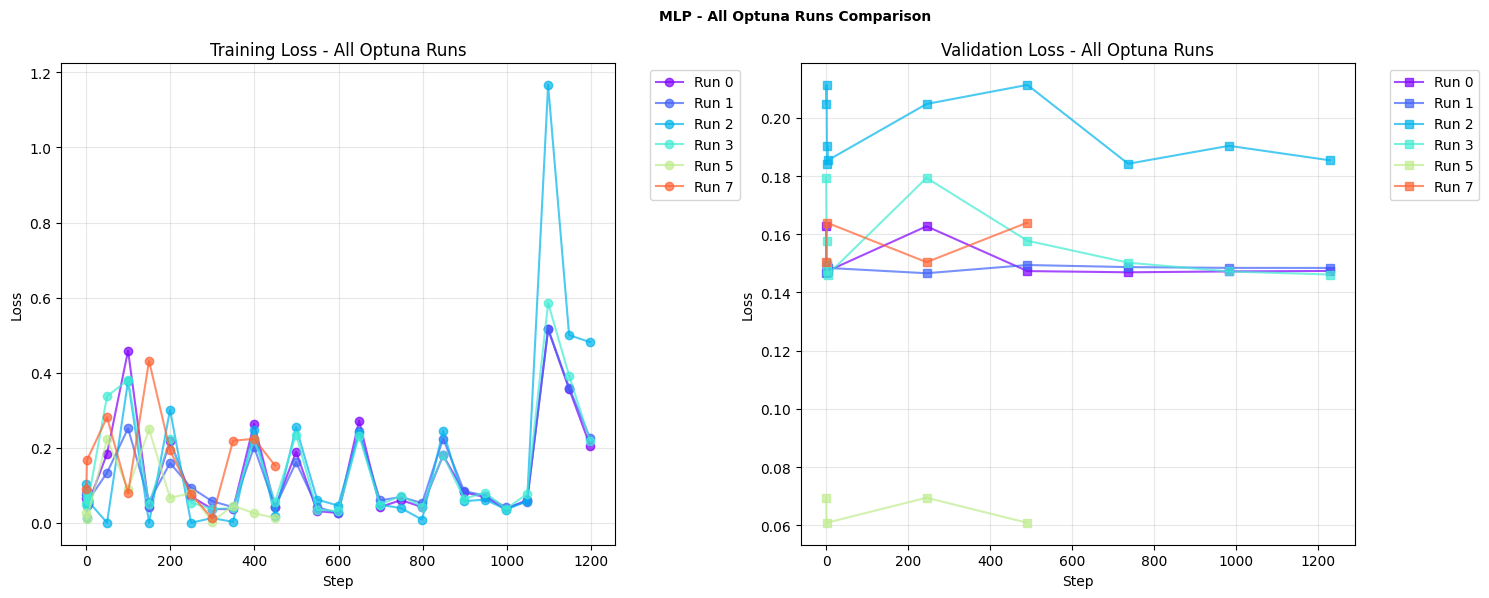

Graphs exported to: c:\Users\LUIS_FELIPE\Desktop\PROJETO_PESS_DADOS\outputs
Saved all runs comparison plot: c:\Users\LUIS_FELIPE\Desktop\PROJETO_PESS_DADOS\outputs\all_runs_comparison_KAN.png


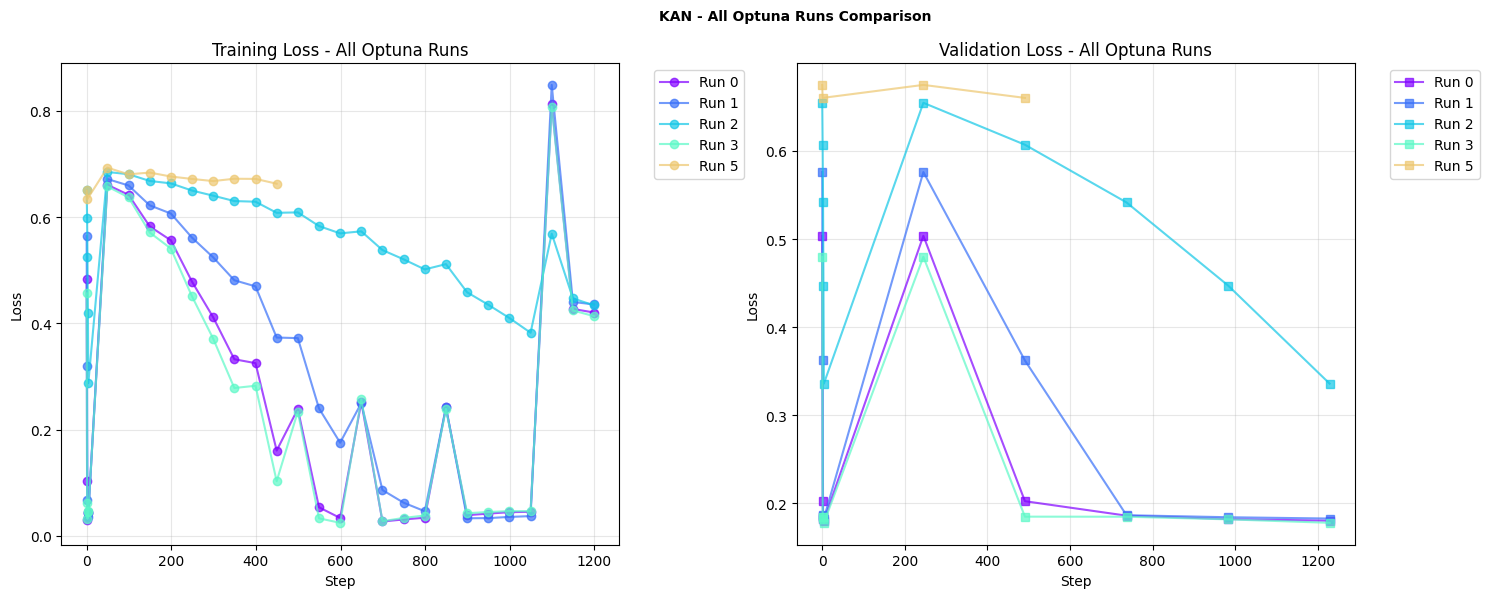

Graphs exported to: c:\Users\LUIS_FELIPE\Desktop\PROJETO_PESS_DADOS\outputs
       train_loss_avg  epoch_avg  val_loss_avg  val_prec_avg  val_rec_avg  val_f_beta_avg  val_roc_auc_avg  best_val_loss_avg  val_f1_avg
model                                                                                                                                    
MLP          0.175031   0.545455      0.157204      0.752786     0.771390        0.742944              0.0           0.164005    0.761592
KAN          0.669548   0.545455      0.667512      0.632108     0.621508        0.739729              0.0           0.660138    0.625495
BEST MODEL: *MLP* WITH F-BETA: 0.7429443359375


In [ ]:
import mlflow
from typing import Literal
from DataProcesser.graph import train_metrics

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"sqlite:///{PATH_CODE}/mlflow.db")
os.environ["OPTUNA_BEST_RUN_PREFIX"] = "best_run"
# --------#
ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
models: list[ARQ_TYPE] = ["MLP", "KAN"]
os.environ["OPTUNA"] = "True"
# Saves directly to env output dir
output_dir = PATH_OUTPUT_DIR
if os.environ["AMBIENTE"] == "KAGGLE":
    output_dir = PATH_DATASET.parent

compare_df = train_metrics(models, output_dir, residual=True)
compare_df.to_csv(output_dir / "results.csv")
print(compare_df.to_string())

ser_fbeta = compare_df["val_f_beta_avg"].sort_values(ascending=False)

#pega melhor modelo com base no FBETA
best_model, fbeta_value = next(ser_fbeta.items())
print(f"BEST MODEL: *{best_model}* WITH F-BETA: {fbeta_value}")

os.environ["BEST_MODEL"] = str(best_model)

## Analyse Best Model Performance

In [ ]:
from Models.mlp import MLP

from Models.kan import MyKan

## NOTE: CONSIDERING THAT model is STILL IN RAM!!!




## MLFlow's Dashboard (Only works outside of Kaggle)
### Download the training results from Kaggle and paste them into a cloned folder of the repository

In [ ]:
import shutil
import subprocess
from pathlib import Path
import pathlib


def see_model(database: pathlib.Path, folder: pathlib.Path):
    subprocess.Popen(
        [
            "mlflow",
            "ui",
            "--backend-store-uri",
            f"sqlite:///{database}",
            "--default-artifact-root",
            folder,
            "--host",
            "127.0.0.1",
            "--port",
            "5000",
        ]
    )


if __name__ == "__main__":
    PATH_RES_ZIPADO = Path(
        "C:\\Users\\LUIS_FELIPE\\Downloads\\resultado_kaggle_stroke_1.zip"
    )
    DIR = Path(Path.cwd(), PATH_RES_ZIPADO.name.replace(".zip", ""))
    print(f"DIR: {DIR}")
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir()
    shutil.unpack_archive(PATH_RES_ZIPADO, DIR)

    print("COMECANDO SUBPROCESSO!\n")
    see_model(DIR / "mlflow.db", DIR / "mlruns")
